### Train XGBoost

In [21]:
import pandas as pd
from utils.constants import *
from sklearn.model_selection import KFold, StratifiedShuffleSplit,ShuffleSplit, StratifiedKFold
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn import ensemble, svm, tree, linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import Normalizer, MaxAbsScaler, MinMaxScaler, StandardScaler, QuantileTransformer, RobustScaler, PowerTransformer
from sklearn.metrics import root_mean_squared_error,root_mean_squared_log_error, r2_score, median_absolute_error,mean_absolute_percentage_error,mean_absolute_error, max_error
import xgboost as xgb
# REF: SCALERS -- https://medium.com/@daython3/scaling-your-data-using-scikit-learn-scalers-3d4b584107d7
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
import pickle

In [22]:
from sklearn.preprocessing import LabelEncoder
file_name = r'model_assets/xgb_SimpleImputers_OutliersRemoved_NoVehCond.pkl'

In [66]:
features = ['curb_weight', 'power', 'cylinder_cnt', 'omv', 'dereg_value',
            'car_age', 
            
            'depreciation', 'arf','coe', 'road_tax',
       'engine_cap', 'depreciation', 'mileage', 'no_of_owners', 
            'type_of_vehicle_bus/mini bus', 'type_of_vehicle_hatchback',
       'type_of_vehicle_luxury sedan', 'type_of_vehicle_mid-sized sedan',
       'type_of_vehicle_mpv', 'type_of_vehicle_others',
       'type_of_vehicle_sports car', 'type_of_vehicle_stationwagon',
       'type_of_vehicle_suv', 'type_of_vehicle_truck',
        'coe car', 'parf car', 
       'rare & exotic', 'emission_data']

In [30]:
best_xgb = pickle.load(open(file_name, "rb"))

name = 'SimpleImputers_OutliersRemoved_NoVehCond'
train_dir = rf'./processed_dataset/train_{name}.csv'
val_dir = rf'./processed_dataset/val_{name}.csv'
test_dir = rf'./processed_dataset/test_{name}.csv'

train_df = pd.read_csv(train_dir)
val_df = pd.read_csv(val_dir)
test_df = pd.read_csv(test_dir)

In [41]:
X_train = train_df[features].values
y_train = train_df['price'].values
print(X_train, y_train)
X_val = val_df[features].values
y_val = val_df['price'].values

X_test= test_df[features].values


[[ 1.9113961  -0.10156942 -0.07219796 ...  0.          0.
   0.00948373]
 [-2.18378945 -1.38312028 -0.07219796 ...  0.          0.
   0.00948373]
 [-0.50634495 -1.10514056 -0.07219796 ...  1.          0.
   0.00948373]
 ...
 [-1.8988604  -1.38312028 -0.07219796 ...  1.          0.
  -2.10962297]
 [ 0.15367628  2.30895152  2.42066173 ...  1.          1.
   2.8131749 ]
 [ 0.76281726  1.18846539 -0.07219796 ...  0.          0.
   0.00948373]] [ 89800.    700.  64800. ...  73800. 649900.  53888.]


In [32]:
# Predict on the training and holdout sets
y_train_pred = best_xgb.predict(X_train)
y_val_pred = best_xgb.predict(X_val)

# Calculate metrics
train_rmse = root_mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_max_error = max_error(y_train, y_train_pred)

holdout_rmse = root_mean_squared_error(y_val, y_val_pred)
holdout_r2 = r2_score(y_val, y_val_pred)
holdout_mae = mean_absolute_error(y_val, y_val_pred)
holdout_max_error = max_error(y_val, y_val_pred)
holdout_mape = mean_absolute_percentage_error(y_val, y_val_pred)

# Print metrics to compare
print(f"train_rmse: {train_rmse}")
print(f"train_mae: {train_mae}")
print(f"train_max_error: {train_max_error}")

print(f"holdout_rmse: {holdout_rmse}")
print(f"holdout_r2: {holdout_r2}")
print(f"holdout_mae: {holdout_mae}")
print(f"holdout_max_error: {holdout_max_error}")
print(f"holdout_mape: {holdout_mape}")


train_rmse: 6220.560673218439
train_mae: 4040.474540799713
train_max_error: 82312.0
holdout_rmse: 24486.921592299706
holdout_r2: 0.9708919150841645
holdout_mae: 6655.910725231934
holdout_max_error: 1104105.1484375
holdout_mape: 0.06937811645863687


### Combine dataset for training

In [33]:
combined_df = pd.concat([train_df, val_df], ignore_index=True)

In [67]:
x_combined_train = combined_df[features].values
y_combined_train = combined_df['price'].values


In [68]:
xgb_reg = xgb.XGBRegressor(subsample=0.6, reg_lambda=1.5, reg_alpha=1, n_estimators=500, max_depth=5, learning_rate=0.1, colsample_bytree= 1.0, random_state=42)


In [69]:
xgb_reg.fit(x_combined_train, y_combined_train)

KeyboardInterrupt: 

In [43]:
name = "SimpleImputers_OutliersRemoved_NoVehCond"

In [44]:
pickle.dump(xgb_reg, open(rf"C:/Users/kan_h/Desktop/Kan Hon/Admin/NUS MComp/AY2425_Sem1/CS5228/cs5228-project/CS5228_project/model_assets/xgb_{name}_combined.pkl", "wb"))


In [42]:
y_test = xgb_reg.predict(X_test)


In [45]:
test_df['Predicted'] = y_test


In [48]:
test_df['id'] = test_df.index
test_df.Predicted = test_df.Predicted.apply(lambda x:round(x / 100.0) * 100.0)
submission = test_df[['id','Predicted']]
submission.head()

,id,Predicted
0,0,19600.0
1,1,34500.0
2,2,145800.0
3,3,78200.0
4,4,25400.0


In [50]:
submission.to_csv(rf'./submission/submission-{name}-xgb-train-val-combined.csv',index=False)


### SHAP

In [51]:
import shap

In [53]:
explainer = shap.TreeExplainer(best_xgb)


In [54]:
shap_values = explainer.shap_values(X_val)

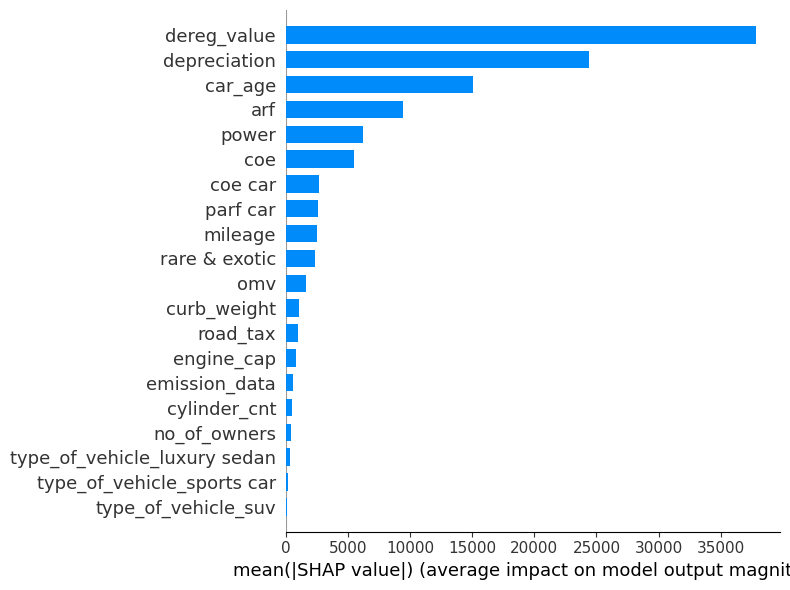

In [64]:
shap.summary_plot(shap_values, X_val, plot_type="bar", feature_names=features, plot_size=[8,6])


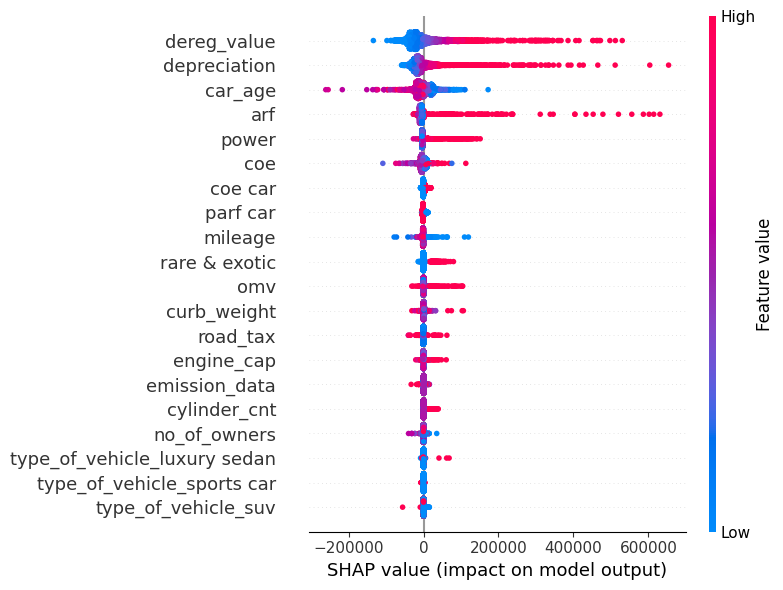

In [65]:
shap.summary_plot(shap_values, X_val, feature_names=features, plot_size=[8,6])


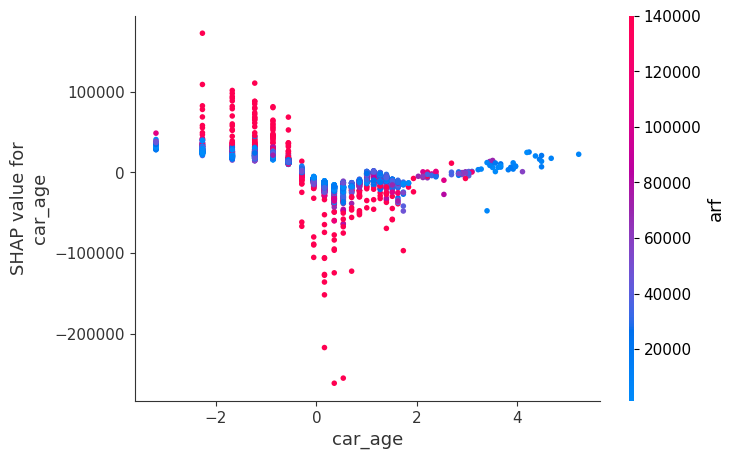

In [58]:
shap.dependence_plot('car_age', shap_values, X_val, feature_names=features, interaction_index='auto')


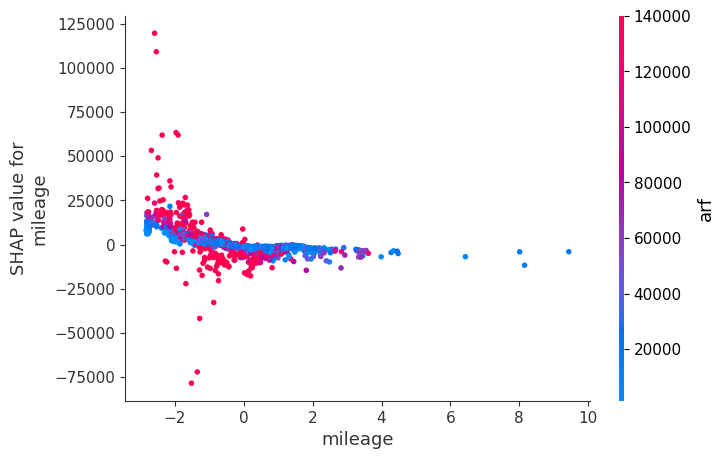

In [59]:
shap.dependence_plot('mileage', shap_values, X_val, feature_names=features, interaction_index='auto')


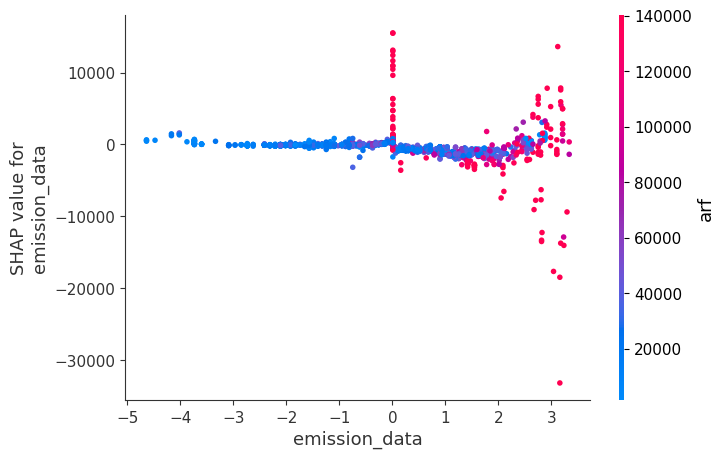

In [60]:
shap.dependence_plot('emission_data', shap_values, X_val, feature_names=features, interaction_index='auto')


### LIME

In [173]:
import lime
from lime.lime_tabular import LimeTabularExplainer
# Reading the dataset
train_df = pd.read_csv(f"{local_path}/{folder}/{train_dataset}")
val_df = pd.read_csv(f"{local_path}/{folder}/{val_dataset}")


# Selection
imputer = impute_choice[impute_type]
scaler = scaler_choice[scaler_type]
model = model_choice[model_type]

# Average cv score -- limitation is that it does not give best model
# cv = cross_validate(model, X, y, cv=5, return_train_score=True)
# Prepare data

# le = LabelEncoder()
# train_df['color_code'] = le.fit_transform(train_df['type_of_vehicle'])
# val_df['color_code'] = le.transform(val_df['type_of_vehicle'])
# features = ['curb_weight', 'power', 'cylinder_cnt', 'omv', 'dereg_value', 'car_age', 'depreciation', 'arf','coe', 'road_tax',
#        'engine_cap', 'depreciation', 'mileage', 'no_of_owners', 'type_of_vehicle_luxury sedan', 'type_of_vehicle_sports car', 
#         'coe car', 'parf car', 'color_code',
#        'rare & exotic', 'emission_data']

train_df[features] = imputer.fit_transform(train_df[features])
val_df[features] = imputer.transform(val_df[features])

# Fit and transform the numerical columns
train_df[features] = scaler.fit_transform(train_df[features])
val_df[features] = scaler.transform(val_df[features])

X_train = train_df[features]
y_train = train_df['price']
X_val = val_df[features]
y_val = val_df['price']


In [175]:

# Initialize the explainer
explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    # class_names=data.target_names,  # Class names if it's a classification problem
    mode='regression'  # Set to 'regression' for regression models
)



In [191]:
# Choose an instance to explain (e.g., first instance in the test set)
j = 5
instance = X_val.iloc[j].values

explanation = explainer.explain_instance(
    data_row=instance,
    predict_fn=best_xgb.predict  # Use predict for regression
)
# Display the explanation
explanation.show_in_notebook(show_table=True, show_all=False)

In [192]:
val_df.iloc[5:7]

,listing_id,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,...,imported used vehicle,low mileage car,opc car,parf car,premium ad car,rare & exotic,sgcarmart warranty cars,sta evaluated car,vintage cars,emission_data
5,1326610,Honda HR-V 1.5A DX,honda,hr-v,one of the lowest depreciation in the market! ...,2018.0,NaN,17-may-2018,suv,parf car,...,0,0,0,1.0,0,0.0,0,0,0,0.2
6,1306534,Ferrari 488 Spider,ferrari,488,"single owner low mileage agent ital auto unit,...",2017.0,NaN,24-jul-2018,sports car,"parf car, premium ad car, low mileage car",...,0,1,0,1.0,1,0.0,0,0,0,0.2
